In [3]:
%%time

!pip install vaderSentiment
!pip install polyglot pyicu Morfessor
!pip install pycld2
!pip install rake_nltk

import pandas as pd
import numpy as np
from PIL import Image
import re 
import seaborn as sns
import string
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy import lemmatizer
from spacy.tokenizer import Tokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
import altair as alt
from plotly.offline import iplot
import plotly.graph_objs as go
import plotly.express as px
from collections import Counter
from polyglot.text import Text, Word 
from polyglot.downloader import downloader

nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
downloader.download("embeddings2.en") 
downloader.download("ner2.en")

     |████████████████████████████████| 133kB 3.5MB/s 
     |████████████████████████████████| 235kB 5.5MB/s 
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=52557 sha256=9884251059708bf15662b581d7931bc26a4076cb76a6f7af88c3a1e591fa1117
  Stored in directory: /root/.cache/pip/wheels/5e/91/ef/f1369fdc1203b0a9347d4b24f149b83a305f39ab047986d9da
  Created wheel for pyicu: filename=PyICU-2.5-cp36-cp36m-linux_x86_64.whl size=1252705 sha256=f58490472b65a1037d484762f4e89bb7e64b8f773abf8bb63c9af72c31892d47
  Stored in directory: /root/.cache/pip/wheels/07/3a/28/09f90c38785945ddf9af61b7add1aa62a740f40e259626ef3a
Successfully built polyglot pyicu
     |████████████████████████████████| 41.4MB 73kB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp36-cp36m-linux_x86_64.whl size=9833505 sha256=318e9160c6c3d751033135d0037d9394e2b6feff509e896e482b46f3b249d068
  Stored in directory: /root/.cache/pip/wheels/c6/8f/e9/08a1a8932a490175bd140206cd86a3dbcfc70498100de11079


In [4]:
amadf = pd.read_csv('amazon_co-ecommerce_sample.csv')
amadf.dropna(subset=['customer_reviews'], inplace=True) #null values

In [5]:
amadf_sorted = amadf.drop(columns = ['uniq_id', 'number_available_in_stock', 'number_of_answered_questions', 'customers_who_bought_this_item_also_bought', 'description', 'product_information', 'product_description', 'items_customers_buy_after_viewing_this_item', 'customer_questions_and_answers'])
amadf_sorted.reset_index(inplace=True)
amadf_sorted.head(75)

,index,product_name,manufacturer,price,number_of_reviews,average_review_rating,amazon_category_and_sub_category,customer_reviews,sellers
0,0,Hornby 2014 Catalogue,Hornby,£3.42,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,1,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."
2,2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel..."
3,3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,1,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN
4,4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,3,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Birthday present // 5.0 // 14 April 2014 // By...,NaN
...,...,...,...,...,...,...,...,...,...
70,70,Hornby R1174 Breakdown Hauler Train Set,Hornby,£74.99,4,4.8 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,"Excellent small starter trainset, with a prett...","{""seller""=>[{""Seller_name_1""=>""Toy Arena"", ""Se..."
71,72,[NEW] Pureoroko C-58 water steam [NEW],Train,£27.60,1,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,but now working well and a great item. // 5.0 ...,"{""seller""=>[{""Seller_name_1""=>""Sukiyaki JP"", ""..."
72,73,Train Tech SK2 Home Signal Kit with R/G LEDs,Train Tech,£8.00,1,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Lighti...,Five Stars // 5.0 // 25 Mar. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""Gaugemaster"", ""S..."
73,74,Kato 11-105 Small Type Moter Unit (for Bandai'...,Kato,£11.01,3,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Top quality chassis // 5.0 // 27 Aug. 2013 // ...,"{""seller""=>[{""Seller_name_1""=>""Santa Trading J..."


In [8]:
amadf_sorted['sor_review'] = amadf_sorted['customer_reviews'].str.split(pat='//')
amadf_sorted.head()

,index,product_name,manufacturer,price,number_of_reviews,average_review_rating,amazon_category_and_sub_category,customer_reviews,sellers,sor_review
0,0,Hornby 2014 Catalogue,Hornby,£3.42,15,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ...",[Worth Buying For The Pictures Alone (As Ever)...
1,1,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,2,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ...","[Four Stars , 4.0 , 18 Dec. 2015 , By\n ..."
2,2,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,17,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel...","[**Highly Recommended!** , 5.0 , 26 May 2015..."
3,3,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,1,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN,"[I love it , 5.0 , 22 July 2013 , By\n \..."
4,4,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,3,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,Birthday present // 5.0 // 14 April 2014 // By...,NaN,"[Birthday present , 5.0 , 14 April 2014 , B..."


In [10]:
rat = []
rev=[]
pro=[]
for i,j in enumerate(amadf_sorted['sor_review']):
  for k,l in enumerate(j):
    if re.search(r'^(\d\.\d)$', l.strip()):
      if 'ecx.images' not in j[k-1].strip(): 
        rev.append(j[k-1].strip())
        pro.append(amadf_sorted['product_name'][i])
        rat.append(l.strip())

In [11]:
rat = list(map(float, rat))
len(rat)

29517

###***Removing Punctuations, Stop Words and Emojis***



In [12]:
rev_copy = rev.copy()

In [13]:
punctuations = string.punctuation
stop_words = list(STOP_WORDS)
stop_words.extend(
    ["five", "star", "stars", "good", "nice", "buy", "great", "buying", "value", "four", "purchase", "excellent",
     "classic", "love", "item", "awesome", "day", "review", "ultra", "fast", "delivery", "item", "year", "£", "price", 'grand', "money",
     "recommend",
     "recommended", "company", 'hi', "lovely", "young", "old", "sure", "simple", "age", "do", "fine", "clear", 'come', 'lol',
     'please',
     'maybe', 'someday', 'best'])
stop_words = set(stop_words)

def decontracted(phrase): 
  phrase = phrase.lower()
  phrase = re.sub(r"won\'t", "will not", phrase) 
  phrase = re.sub(r"can\'t", "can not", phrase) 
  phrase = re.sub(r"n\'t", " not", phrase) 
  phrase = re.sub(r"n\ \'\ t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase) 
  phrase = re.sub(r"\ \'\ ve", " have", phrase) 
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\ \'\ s", " is", phrase) 
  phrase = re.sub(r"\'d", " would", phrase) 
  phrase = re.sub(r"\'ll", " will", phrase) 
  phrase = re.sub(r"\'t", " not", phrase) 
  phrase = re.sub(r"\ \'\ t", " not", phrase) 
  phrase = re.sub(r"\'ve", " have", phrase) 
  phrase = re.sub(r"\ \'\ ve", " have", phrase) 
  phrase = re.sub(r"\'m", " am", phrase)
  phrase = re.sub(r"\.", " . ", phrase) 
  phrase = re.sub(r'\s+',' ',phrase)
  phrase = re.sub("<|>", " ", phrase)
  phrase = re.sub(r"\d+\w+|\w+\d+|\d+", " ", phrase)
  return phrase

for i,text in enumerate(rev_copy):
  rev_copy[i] = decontracted(text)

In [14]:
def stpw_rem(sentences):
  if type(sentences) is str:
    sentences = word_tokenize(sentences,"english")
  b=" ".join(word for word in sentences if word.lower().strip() not in stop_words)  # Removing stopwords
  return b

for i,text in enumerate(rev_copy):
  rev_copy[i] = stpw_rem(text)

In [15]:
def punc_rem(sentences):
  
  
  sentences = sentences.translate(str.maketrans('', '', punctuations)) # Removing Punctuations
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', sentences) # Emoji removal

for i,text in enumerate(rev_copy):
  rev_copy[i] = punc_rem(text)

###***Lemmatization***

In [16]:
lemmatizer = WordNetLemmatizer()
def lemma_id(sentence):
  doc = word_tokenize(sentence)
  lem = " ".join(lemmatizer.lemmatize(token) for token in doc)

  return lem 

for i,text in enumerate(rev_copy):
  rev_copy[i] = lemma_id(text)


In [17]:

for i,text in enumerate(rev_copy):
  rev_copy[i] = decontracted(text)

In [18]:
#HTML link removal

def linkrem(i):
  i = re.sub(r'(www.\S+|http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)',"" , i)
  return i

for i,text in enumerate(rev_copy):
  rev_copy[i] = linkrem(text)

In [19]:
rev_df = pd.DataFrame({'Review':rev_copy, 'Rating': rat, 'product_name':pro})
rev_df.head(12)

,Review,Rating,product_name
0,worth picture,4.0,Hornby 2014 Catalogue
1,magic growing boy given new hornby catalogue i...,5.0,Hornby 2014 Catalogue
2,amazing detail credit photographer book worthy...,5.0,Hornby 2014 Catalogue
3,purchased behalf dad asking look gauge engine ...,5.0,Hornby 2014 Catalogue
4,needed offer hornby way train minded included ...,5.0,Hornby 2014 Catalogue
5,collect glossy picture catalog collect catalogue,5.0,Hornby 2014 Catalogue
6,book extremely useful insight future christmas...,5.0,Hornby 2014 Catalogue
7,useful info someonelike starting hobby year ho...,5.0,Hornby 2014 Catalogue
8,,4.0,FunkyBuys® Large Christmas Holiday Express Fes...
9,happy communication funkybuys,5.0,FunkyBuys® Large Christmas Holiday Express Fes...


In [20]:
new = pd.merge(amadf_sorted, rev_df)

In [21]:
new = new.drop(columns=['sor_review', 'customer_reviews'])

In [22]:
for i,txt in enumerate(new['Review']):
  if len(word_tokenize(txt)) < 4:
    new = new.drop(i)
new = new.sort_values(by=['amazon_category_and_sub_category']).reset_index()
new = new.drop(columns=['level_0'])

In [ ]:
new.shape

(19624, 10)

In [23]:
new.head(500)

,index,product_name,manufacturer,price,number_of_reviews,average_review_rating,amazon_category_and_sub_category,sellers,Review,Rating
0,733,1Kg Bulk Bags Of Ultra Fine Glitter (2006 Gold),FDC,£11.99,13,5.0 out of 5 stars,Arts & Crafts > Art & Craft Supplies > Glitter,"{""seller""=>{""Seller_name_1""=>""Celebration Cent...",exactly needed described sparklingly,5.0
1,733,1Kg Bulk Bags Of Ultra Fine Glitter (2006 Gold),FDC,£11.99,13,5.0 out of 5 stars,Arts & Crafts > Art & Craft Supplies > Glitter,"{""seller""=>{""Seller_name_1""=>""Celebration Cent...",product go long way,5.0
2,733,1Kg Bulk Bags Of Ultra Fine Glitter (2006 Gold),FDC,£11.99,13,5.0 out of 5 stars,Arts & Crafts > Art & Craft Supplies > Glitter,"{""seller""=>{""Seller_name_1""=>""Celebration Cent...",go long long way got load left crafty idea,5.0
3,5109,Polyester Multi-Colour Bunting,Pams,£2.59,2,5.0 out of 5 stars,Arts & Crafts > Art & Craft Supplies > Thread ...,"{""seller""=>{""Seller_name_1""=>""Mr Bens Fancy Dr...",loved long amazing bright colour need brighten...,5.0
4,671,Motion Sand® Learning Bucket Playset,Motion Sand,£6.99,28,4.9 out of 5 stars,Arts & Crafts > Art Sand,"{""seller""=>[{""Seller_name_1""=>""net_price_direc...",y easy build shape,5.0
...,...,...,...,...,...,...,...,...,...,...
495,1211,Hama Beads - Solid Mix 3000 Tub (Midi Beads),Hama,£6.42,45,4.5 out of 5 stars,Arts & Crafts > Children's Craft Kits > Bead A...,"{""seller""=>[{""Seller_name_1""=>""Just Childsplay...",disagree previous state board supplied hama ki...,5.0
496,1211,Hama Beads - Solid Mix 3000 Tub (Midi Beads),Hama,£6.42,45,4.5 out of 5 stars,Arts & Crafts > Children's Craft Kits > Bead A...,"{""seller""=>[{""Seller_name_1""=>""Just Childsplay...",order product turned quickly problem hour fun,5.0
497,1211,Hama Beads - Solid Mix 3000 Tub (Midi Beads),Hama,£6.42,45,4.5 out of 5 stars,Arts & Crafts > Children's Craft Kits > Bead A...,"{""seller""=>[{""Seller_name_1""=>""Just Childsplay...",oh fun hour creating beautiful piece hang wear...,1.0
498,1211,Hama Beads - Solid Mix 3000 Tub (Midi Beads),Hama,£6.42,45,4.5 out of 5 stars,Arts & Crafts > Children's Craft Kits > Bead A...,"{""seller""=>[{""Seller_name_1""=>""Just Childsplay...",came quickly description accurate tub bead peg...,5.0


###***Visualization***
Word Cloud

In [ ]:
wc_data=[]
for i in new[new.manufacturer == 'Hornby']['Review']:
  wc_data.extend(word_tokenize(i))

In [ ]:
pos_wds = ''
with open('/content/drive/My Drive/Group2 - Parsing product and user review data/positive-negative word list/positive-words.txt', 'r') as f:
  words = f.readlines()
  for i in wc_data:
    if i+'\n' in words:
      pos_wds = pos_wds + ' ' + i

In [ ]:
neg_wds = ''
with open('/content/drive/My Drive/Group2 - Parsing product and user review data/positive-negative word list/negative-words.txt','r+',encoding="ISO-8859-1") as f:
  words = f.readlines()
  for i in wc_data:
    if i+'\n' in words:
      neg_wds = neg_wds + ' ' + i

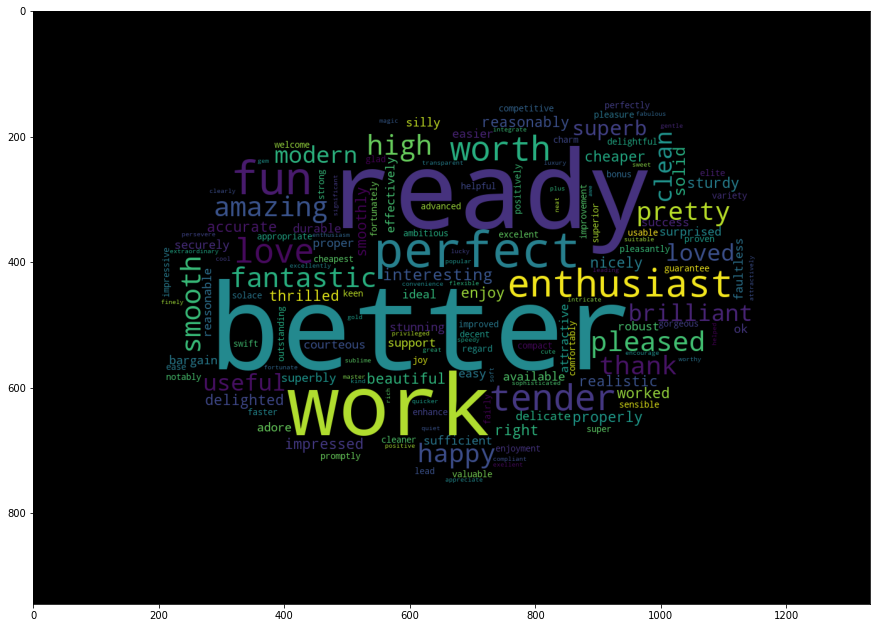

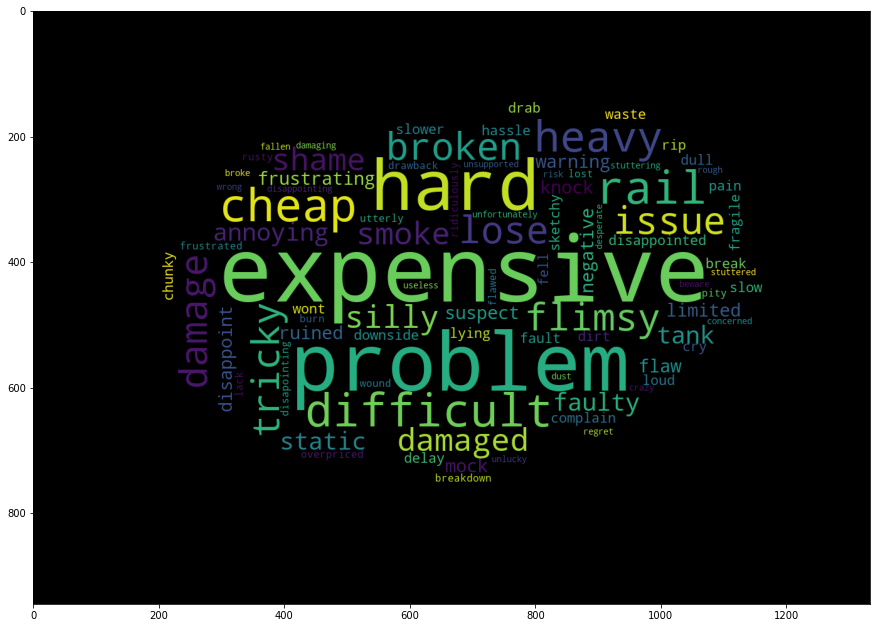

In [ ]:
mask = np.array(Image.open("cloud.png"))
wc = WordCloud(mask = mask).generate(pos_wds)
plt.figure(figsize=[15,15])
plt.imshow(wc)
mask = np.array(Image.open("cloud.png"))
wc = WordCloud(mask = mask).generate(neg_wds)
plt.figure(figsize=[15,15])
plt.imshow(wc)

In [ ]:
a = amadf_sorted['manufacturer'][:100]
b = amadf_sorted['price'][:100]
c = amadf_sorted['product_name'][:100]
d = amadf_sorted['amazon_category_and_sub_category'][:100]
df = pd.DataFrame(a)
df['price'] = b
df['prod'] = c
df['cat'] = d
df =df.dropna(subset=['price'])
df['price'] =df['price'].str.strip('£')
df['price'] = df['price'].astype('float')

In [ ]:
r= new.groupby(['manufacturer', 'product_name', 'amazon_category_and_sub_category','price'], as_index=False)['Rating'].aggregate(np.mean)

r['price'] =r['price'].str.replace('£', '')
r['price'] = r['price'].str.replace(',','')
r['price'] = r['price'].str.replace(' - ','')
r['price'] = r.apply(lambda x : x['price'][:5], axis=1)
r['price'] = r['price'].astype('float')
r = r.sort_values('Rating', ascending=False).reset_index()
r.head(4576)

Text(0.5, 0, 'Manufacturer')

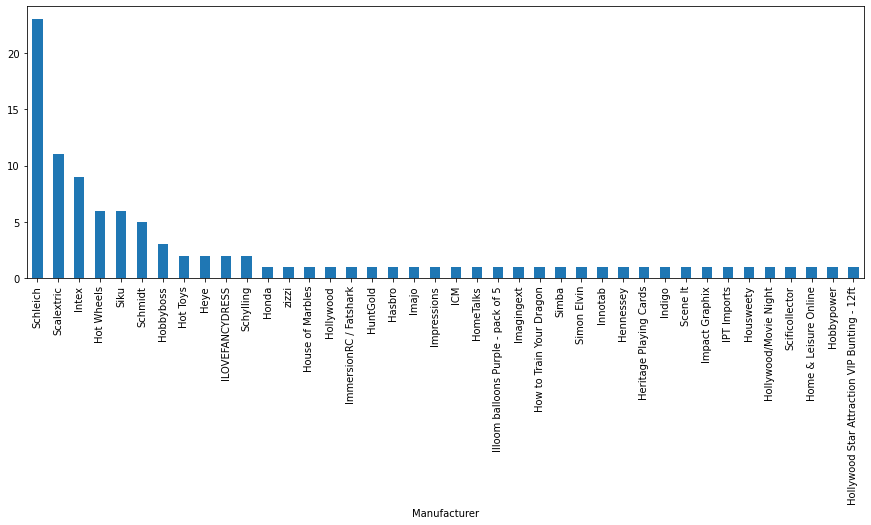

In [ ]:
['manufacturer'][:100].value_counts().plot.bar(figsize=[15,5]).set_xlabel('Manufacturer')

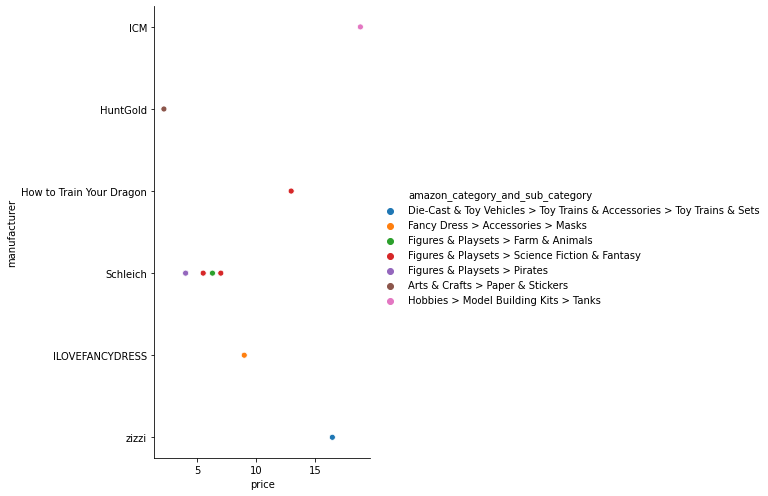

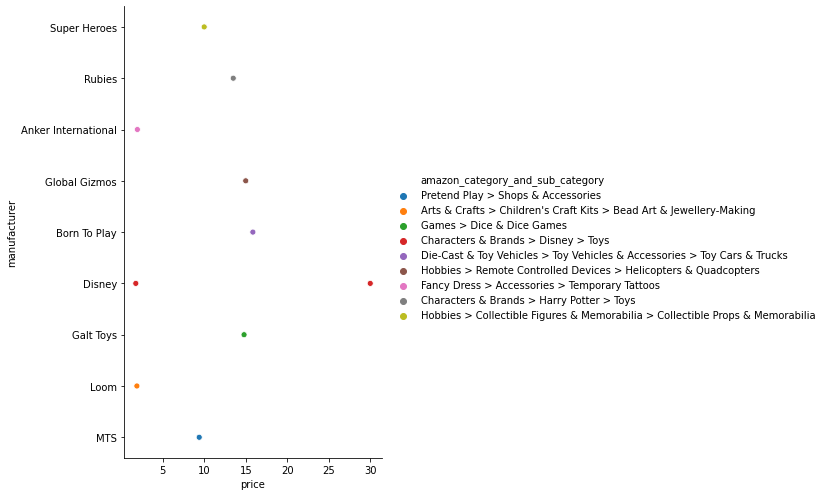

In [ ]:
sns.relplot(data=r[:10], x='price', y='manufacturer', hue='amazon_category_and_sub_category',height=7)
sns.relplot(data=r[:-50:-5], x='price', y='manufacturer', hue='amazon_category_and_sub_category',height=7)

In [ ]:
alt.Chart(r[4050:4476:5]).mark_point().encode(
    x='manufacturer',
    y='Rating',
).interactive()

alt.Chart(...)

In [ ]:
f = go.FigureWidget([go.Scatter(x=r['price'][-5000:-1], y=r['Rating'][-5000:-1], mode='markers')])
f.show()

In [ ]:
from nltk.probability import FreqDist
wc_data = ' '.join(i for i in new['Review'])
tokens = word_tokenize(wc_data)
fdist=FreqDist()
for words in tokens:
  fdist[words.lower()]+=1

In [ ]:
wd_dict=dict(fdist.most_common(100))
val=wd_dict.values()
key=wd_dict.keys()
wd_df = pd.DataFrame(key,columns=['key'])
wd_df['val'] = val

In [ ]:
f = go.FigureWidget([go.Scatter(y=wd_df['val'], x=wd_df['key'], mode='markers')])
f.show()

In [ ]:
fig = px.density_contour(r[:-10:-2], x="Rating", y="amazon_category_and_sub_category", facet_col="price")
fig.update_traces(contours_coloring="fill", contours_showlabels = True)
fig.show()

In [ ]:
pos_rev = ' '.join(i for i in new.loc[new['Rating'] > 3]['Review'])
pos_rev = word_tokenize(pos_rev)
len(pos_rev)

344964

In [ ]:
neg_rev = ' '.join(i for i in new.loc[new['Rating'] <= 3]['Review'])
neg_rev = word_tokenize(neg_rev)
len(neg_rev)

48533

In [ ]:
pos_rev_pos_wds = []
with open('/content/drive/My Drive/Group2 - Parsing product and user review data/positive-negative word list/positive-words.txt', 'r') as f:
  words = f.readlines()
  for i in pos_rev:
    if i+'\n' in words:
      pos_rev_pos_wds.append(i)

pos_rev_pos_wds = dict(Counter(pos_rev_pos_wds))
pos_rev_pos_wds = pd.DataFrame(pos_rev_pos_wds, index=[0])
pos_rev_pos_wds = pos_rev_pos_wds.T.reset_index().reindex(columns=['index', 0])
pos_rev_pos_wds = pos_rev_pos_wds.rename(columns={'index': 'Words', 0:'Count'})

In [ ]:
pos_rev_neg_wds = []
with open('/content/drive/My Drive/Group2 - Parsing product and user review data/positive-negative word list/negative-words.txt','r+',encoding="ISO-8859-1") as f:
  words = f.readlines()
  for i in pos_rev:
    if i+'\n' in words:
      pos_rev_neg_wds.append(i)

pos_rev_neg_wds = dict(Counter(pos_rev_neg_wds))
pos_rev_neg_wds = pd.DataFrame(pos_rev_neg_wds, index=[0])
pos_rev_neg_wds = pos_rev_neg_wds.T.reset_index().reindex(columns=['index', 0])
pos_rev_neg_wds = pos_rev_neg_wds.rename(columns={'index': 'Words', 0:'Count'})

In [ ]:
neg_rev_pos_wds = []
with open('/content/drive/My Drive/Group2 - Parsing product and user review data/positive-negative word list/positive-words.txt', 'r') as f:
  words = f.readlines()
  for i in neg_rev:
    if i+'\n' in words:
      neg_rev_pos_wds.append(i)

neg_rev_pos_wds = dict(Counter(neg_rev_pos_wds))
neg_rev_pos_wds = pd.DataFrame(neg_rev_pos_wds, index=[0])
neg_rev_pos_wds = neg_rev_pos_wds.T.reset_index().reindex(columns=['index', 0])
neg_rev_pos_wds = neg_rev_pos_wds.rename(columns={'index': 'Words', 0:'Count'})

In [ ]:
neg_rev_neg_wds = []
with open('/content/drive/My Drive/Group2 - Parsing product and user review data/positive-negative word list/negative-words.txt','r+',encoding="ISO-8859-1") as f:
  words = f.readlines()
  for i in neg_rev:
    if i+'\n' in words:
      neg_rev_neg_wds.append(i)

neg_rev_neg_wds = dict(Counter(neg_rev_neg_wds))
neg_rev_neg_wds = pd.DataFrame(neg_rev_neg_wds, index=[0])
neg_rev_neg_wds = neg_rev_neg_wds.T.reset_index().reindex(columns=['index', 0])
neg_rev_neg_wds = neg_rev_neg_wds.rename(columns={'index': 'Words', 0:'Count'})

In [ ]:
f =px.scatter(x=pos_rev_pos_wds['Words'], y=pos_rev_pos_wds['Count'])
f.show()
f =px.scatter(x=pos_rev_neg_wds['Words'], y=pos_rev_neg_wds['Count'])
f.show()

In [ ]:
f =px.scatter(x=neg_rev_pos_wds['Words'], y=neg_rev_pos_wds['Count'])
f.show()
f =px.scatter(x=neg_rev_neg_wds['Words'], y=neg_rev_neg_wds['Count'])
f.show()

In [24]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(new[new['amazon_category_and_sub_category'] == 'Hobbies > Model Trains & Railway Sets > Rail Vehicles > Trains']['Review'][:15])
tv_matrix = tv_matrix.toarray()

In [25]:
#sentence cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

sim_mat = cosine_similarity(tv_matrix)
sim_df = pd.DataFrame(sim_mat)
sim_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.073165,0.107409,0.087892,0.100868,0.044257,0.062273,0.079420,0.000000,0.008094,0.020393,0.034619,0.050824,0.074640,0.079530
1,0.073165,1.000000,0.133436,0.057472,0.083904,0.077750,0.157464,0.079796,0.000000,0.065519,0.098144,0.078169,0.109396,0.112818,0.032323
2,0.107409,0.133436,1.000000,0.334038,0.138382,0.096269,0.030548,0.000000,0.000000,0.007403,0.018651,0.011603,0.010427,0.136533,0.026655
3,0.087892,0.057472,0.334038,1.000000,0.121601,0.191732,0.110266,0.000000,0.000000,0.059399,0.127390,0.051251,0.062898,0.000000,0.117736
4,0.100868,0.083904,0.138382,0.121601,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109710,0.000000
5,0.044257,0.077750,0.096269,0.191732,0.000000,1.000000,0.170511,0.066009,0.088490,0.118067,0.033384,0.059617,0.073015,0.030547,0.088951
6,0.062273,0.157464,0.030548,0.110266,0.000000,0.170511,1.000000,0.092879,0.044116,0.194048,0.046973,0.184238,0.102736,0.042982,0.125160
7,0.079420,0.079796,0.000000,0.000000,0.000000,0.066009,0.092879,1.000000,0.000000,0.060848,0.000000,0.087763,0.000000,0.155176,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.088490,0.044116,0.000000,1.000000,0.077928,0.000000,0.000000,0.030118,0.041663,0.000000
9,0.008094,0.065519,0.007403,0.059399,0.000000,0.118067,0.194048,0.060848,0.077928,1.000000,0.038319,0.127365,0.035144,0.037962,0.016268


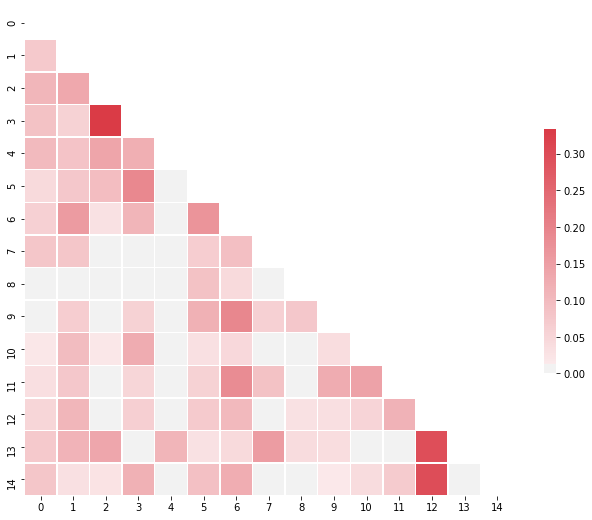

In [26]:
#Heat MAP
mask = np.zeros_like(sim_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

svm = sns.heatmap(sim_df, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
figure = svm.get_figure()

In [27]:
w2v_cat_df = new.copy()
w2v_cat_df = w2v_cat_df.dropna(subset=['amazon_category_and_sub_category'])

In [28]:
#splitting DF on the basis of category (80%/20%)
cat_rev=[]
cat_rev_te=[]
cat=[]
cat_te=[]
for i,txt in enumerate(w2v_cat_df['amazon_category_and_sub_category'].unique()):
  cnt = w2v_cat_df[w2v_cat_df['amazon_category_and_sub_category'] == txt]['Review'].count()
  if int(cnt*0.8) == 0:
    continue
  for k in w2v_cat_df[w2v_cat_df['amazon_category_and_sub_category'] == txt]['Review'].head(int(cnt*0.8)):
    cat_rev.append(k)
    cat.append(txt)
  for j in w2v_cat_df[w2v_cat_df['amazon_category_and_sub_category'] == txt]['Review'][int(cnt*0.8)-cnt:]:
    cat_rev_te.append(j)
    cat_te.append(txt)
  
  

In [29]:
train_cat_df = pd.DataFrame(list(zip(cat_rev,cat)), columns=['Review', 'Category'])
test_cat_df = pd.DataFrame(list(zip(cat_rev_te,cat_te)), columns=['Review', 'Category'])

In [30]:
#Doc2vec
from gensim.test.utils import common_texts
from sklearn import utils
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from tqdm import tqdm

tr_doc = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_cat_df['Review'])]
te_doc = [TaggedDocument(doc, [i]) for i, doc in enumerate(test_cat_df['Review'])]

main_doc =tr_doc + te_doc


model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=15, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(main_doc)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(main_doc)]), total_examples=len(main_doc), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


100%|██████████| 17906/17906 [00:00<00:00, 1553163.22it/s]


In [31]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        vectors[i] = model.docvecs[i]
    return vectors
    
train_vectors_dbow = get_vectors(model_dbow, len(tr_doc), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(te_doc), 300, 'Test')

In [32]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_vectors_dbow, train_cat_df['Category'])
y_pred = logreg.predict(test_vectors_dbow)
print('accuracy %s' % accuracy_score(y_pred, test_cat_df['Category']))
print(classification_report(test_cat_df['Category'], y_pred))

accuracy 0.05813318777292576
                                                                                                                          precision    recall  f1-score   support

                                                                          Arts & Crafts > Art & Craft Supplies > Glitter       0.50      1.00      0.67         1
                                                                                                Arts & Crafts > Art Sand       0.10      0.18      0.13        45
                                                                                             Arts & Crafts > Blackboards       0.00      0.00      0.00         8
                                                                                        Arts & Crafts > Children's Chalk       0.00      0.00      0.00         3
                                                                                   Arts & Crafts > Children's Craft Kits       0.05      0.03      0.04        3

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import gensim
from gensim.models import Word2Vec
import pandas as pd

# w2v_cat_df =pd.read_csv('Final_DB.csv')
# model = Word2Vec(size = 300, window=4, min_count = 15, workers = 5)
# #Preparing Train Set
# df_ri=[]
# for txt in w2v_cat_df['amazon_category_and_sub_category'].unique():
#   for i in w2v_cat_df[w2v_cat_df.amazon_category_and_sub_category == txt]['Review']:
#     df_ri.append(i.split())
# newl=[]
# for i in df_ri:
#   newl.append(list(set(i)))  

# #Building Vocab
# model.build_vocab(newl)
# model.intersect_word2vec_format('/content/drive/My Drive/Classroom/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)
# model.init_sims(replace=True)

# #Training Word2Vec 
# model.train(newl,total_examples=len(newl), epochs=30)

model = gensim.models.KeyedVectors.load_word2vec_format('/content/w2v_amazon.bin', binary=True)

In [ ]:
keys = ['train','puppet','fly','kit','child','gift']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.most_similar(word):
        words.append(similar_word)
        embeddings.append(model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

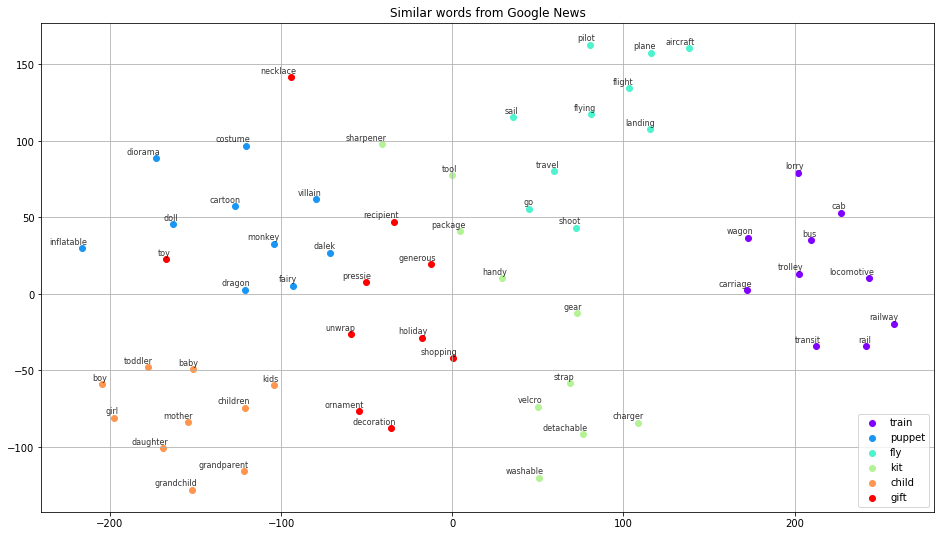

In [5]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=4500, random_state=32,learning_rate=150,n_jobs=5)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Google News', keys, embeddings_en_2d, word_clusters, 1,
                        'similar_words.png')

In [7]:
set_l = []
w2v_cat_df = pd.read_csv('/content/Final_DB.csv')
t= ['train','kite','toy','outdoor','set','flight','child','eraser','puzzle','game',]
for i in w2v_cat_df.amazon_category_and_sub_category.unique():
  for k in t:
    if k in i.lower():
      set_l.append(i)
    try:
      a = dict(model.similar_by_word(k, topn=15)).keys()
    except:
      continue
    for j in a:
      if j in i.lower():
        set_l.append(i)

unl_cat_l = set(w2v_cat_df.amazon_category_and_sub_category.unique().flatten()).symmetric_difference(set_l)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [26]:
strg = " I bought this train set for my son and am a complete novice when it comes to train sets. The Hornby set feels solid and attention is paid to the detail on the train. it comes with a mat, which is actually a giant printed poster. for the long term, a hard backing is needed. The track layout feels like it is the next size up from a basic layout as it already contains an extension pack. The train itself is not huge and looks silly pulling long  passenger carriages (as it would on a real train). It is quite expensive and had I not seen it at a reduced price, I probably would not have bought it (hence 4 / 5). The train can actually go quite fast in both directions. As novice I have discovered several features that must be well known to train set enthusiasts The trains can be tricky to get all wheels on the track. (I think there is an accessory to help with this)Big Long carriages do not like tight bends at speed (they come off).When using points to guide the train onto an inner circuit (I bought more track) you need to get jumper leads from Hornby and these are not included in Extension packs A & B. Without these the train loses power, but I think they are relatively cheap. The Track needs to be cleaned with a cloth, as any grease / dirt can stop the power to the train track has to be carefully aligned when joining one section to another, so continually putting it away and getting it out is time consuming - setting it up on a hard backing is a better solution. My child is very careful with the set and its contents, but not an ideal present for kids who leave it lying around and step on it (the carriages are expensive). I can see why people like train sets and this is a good introductory set with the plethora of accessories and trains etc from Hornby and others we were left wanting to buy more bits and pieces (such as electric rather than manual points) after using this set. | Excellent introduction  to the hobby."

c_dic={}
cat_arr=[]
cat_no=0


def comp_ext(strg):   # Extracting Comapanies
  strg = punc_rem(stpw_rem(strg))
  text = Text(strg)
  company_l=[]
  for i in text.entities:
    company_l.extend(i)

  nlp = spacy.load("en_core_web_sm")
  doc=nlp(strg)
  for ent in doc.ents: 
    if ent.label_ == 'ORG':
      company_l.append(ent.text) 

  tokens = nltk.word_tokenize(strg)
  tagged = nltk.pos_tag(tokens)
  entities = nltk.chunk.ne_chunk(tagged)
  company = [ " ".join(w for w, t in elt) for elt in entities if isinstance(elt, nltk.Tree) ]
  company.extend(company_l)

  company_fin = [i for i in set(company) if len(word_tokenize(i)) < 4]
  return company_fin


def cat_pred(cat, cat_no):   #Predict the Category
  for j in cat.groupby(['amazon_category_and_sub_category'])['Review'].unique():
    m=[]
    m.extend(j)
    tok_rev = Counter(word_tokenize(punc_rem(str(word_tokenize(str(m))))))
    print(tok_rev)
    c=0
    score = 0
    for ele in token_fin:
      if ele in tok_rev.keys():
        c += 1
        score += tok_rev[ele]
        try:
          sim_dic = dict(model.similar_by_word(ele, topn=7)).keys()
        except:
          continue
        for sim_w in sim_dic:
          if sim_w in tok_rev.keys():
            c += 1
            score += tok_rev[ele]
          c_dic[cat_no] = [c,score]
    cat_no += 1
  return c_dic


def _main(company):  # Main function
  flag=0
  for i in company:
    if i in w2v_cat_df.manufacturer.unique():
      flag=1
      print(flag)
      cat = w2v_cat_df[w2v_cat_df.manufacturer.str.lower() == i.lower()][['amazon_category_and_sub_category','Review']]
      cat_arr.extend(cat.amazon_category_and_sub_category.unique())
      c_dict = cat_pred(cat,cat_no)
    
  if flag == 0:
    print(flag)
    c_dict = unla_rev()

  return c_dict


def unla_rev():
#Finding the Most Relevant Word Category
  max=0
  idx=-1
  for i,word in enumerate(t):
    try:
      a = list(dict(model.similar_by_word(word, topn=10)).keys())
    except:
      continue
    a.append(word)
    if max < len(list(set(token_fin).intersection(set(a)))):
      max = len(list(set(token_fin).intersection(set(a))))
      idx = i

  if idx == -1:     # if not found then proceed with unlabeled ones
    cat_list = unl_cat_l
  else:             # else find the all categories present of that word
    set_l=[]
    for i in w2v_cat_df.amazon_category_and_sub_category.unique():
      if t[idx] in i.lower():
        set_l.append(i)
      try:
        a = dict(model.similar_by_word(t[idx], topn=15)).keys()
      except:
        continue
      for j in a:
        if j in i.lower():
          set_l.append(i)
    cat_list = set(set_l)

  for i in cat_list:
    cat = w2v_cat_df[w2v_cat_df.amazon_category_and_sub_category == i][['amazon_category_and_sub_category','Review']]
    leng = len(cat_arr)
    cat_arr.append(i)
    print(leng)
    c_dict = cat_pred(cat,leng)

  return c_dict

    
m=[]
company_fin = comp_ext(strg)
strng = lemma_id(punc_rem(stpw_rem(decontracted(strg))))
token_fin = list(Counter(word_tokenize(strng)).keys())
token_fin = [x for x in token_fin if x.capitalize() not in company_fin and x.upper() not in company_fin]
print(company_fin)
print(token_fin)
if token_fin:
  c_dict = _main(company_fin)

  c_dict = sorted(c_dict.items(), key = lambda kv:(kv[1], kv[0]))
  print(c_dict[::-1])

['Track', 'Hornby']
['bought', 'train', 'set', 'son', 'complete', 'novice', 'come', 'feel', 'solid', 'attention', 'paid', 'detail', 'mat', 'actually', 'giant', 'printed', 'poster', 'long', 'term', 'hard', 'backing', 'needed', 'layout', 'like', 'size', 'basic', 'contains', 'extension', 'pack', 'huge', 'look', 'silly', 'pulling', 'passenger', 'carriage', 'real', 'expensive', 'seen', 'reduced', 'probably', 'direction', 'discovered', 'feature', 'known', 'enthusiast', 'tricky', 'wheel', 'think', 'accessory', 'help', 'big', 'tight', 'bend', 'speed', 'point', 'guide', 'inner', 'circuit', 'need', 'jumper', 'lead', 'included', 'b', 'loses', 'power', 'relatively', 'cheap', 'cleaned', 'cloth', 'grease', 'dirt', 'stop', 'carefully', 'aligned', 'joining', 'section', 'continually', 'putting', 'away', 'getting', 'time', 'consuming', 'setting', 'better', 'solution', 'child', 'careful', 'content', 'ideal', 'present', 'kid', 'leave', 'lying', 'step', 'people', 'introductory', 'plethora', 'etc', 'left', 

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [27]:
for i in c_dict[::-1]:
  print(cat_arr[i[0]])
print(cat_arr)

Hobbies > Model Trains & Railway Sets > Rail Vehicles > Trains
Hobbies > Model Trains & Railway Sets > Rail Vehicles > Locomotives
Hobbies > Model Trains & Railway Sets > Accessories > Landscaping > Track Construction
Die-Cast & Toy Vehicles > Toy Vehicles & Accessories > Scaled Models > Vehicles
['Die-Cast & Toy Vehicles > Toy Vehicles & Accessories > Scaled Models > Vehicles', 'Hobbies > Model Trains & Railway Sets > Accessories > Landscaping > Track Construction', 'Hobbies > Model Trains & Railway Sets > Rail Vehicles > Locomotives', 'Hobbies > Model Trains & Railway Sets > Rail Vehicles > Trains']


In [ ]:
# Word Cloud of Neagtive and Positive Words
pos_w = []
neg_w = []
for i in word_tokenize(strg):
  if sid_obj.polarity_scores(i)['compound'] < -0.3 and len(i) > 2:
    print("Negative Words-",'\n',i)
    neg_w.append(i)
  elif sid_obj.polarity_scores(i)['compound'] > 0.3 and len(i) > 2:
    print("Positive Words-",'\n',i)
    pos_w.append(i)

Positive Words- 
 like
Positive Words- 
 huge
Positive Words- 
 enthusiasts
Positive Words- 
 help
Positive Words- 
 like
Negative Words- 
 loses
Negative Words- 
 dirt
Positive Words- 
 better
Positive Words- 
 solution
Positive Words- 
 ideal
Negative Words- 
 lying
Positive Words- 
 like
Positive Words- 
 good
Positive Words- 
 Excellent


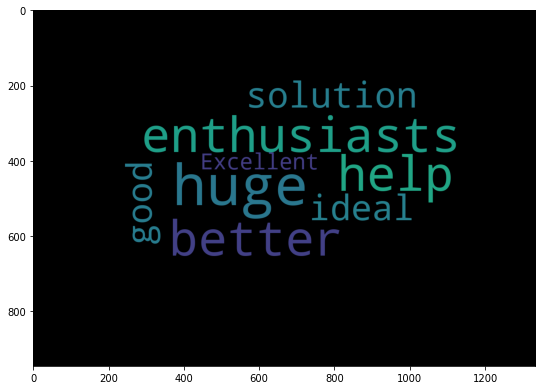

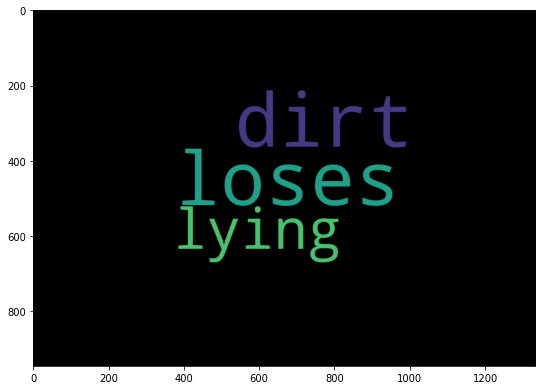

In [ ]:
wc_data = ' '.join(i for i in pos_w)
mask = np.array(Image.open("cloud.png"))
wc = WordCloud(mask = mask).generate(wc_data)
plt.figure(figsize=[9,9])
plt.imshow(wc)

wc_data = ' '.join(i for i in neg_w)
mask = np.array(Image.open("cloud.png"))
wc = WordCloud(mask = mask).generate(wc_data)
plt.figure(figsize=[9,9])
plt.imshow(wc)

In [ ]:
#Keyword and Concept extraction

from rake_nltk import Rake

r = Rake()
a = r.extract_keywords_from_text(strg)

r.get_ranked_phrases_with_scores()[:10]

[(31.0, 'looks silly pulling long passenger carriages'),
 (13.5, 'actually go quite fast'),
 (13.11111111111111, 'people like train sets'),
 (13.1, 'hornby set feels solid'),
 (12.916666666666666, 'track layout feels like'),
 (10.0, 'big long carriages'),
 (9.666666666666666, 'like tight bends'),
 (9.0, 'joining one section'),
 (9.0, 'giant printed poster'),
 (9.0, 'discovered several features')]